# Solving an Inverse Problem with Physics-Informed Neural Networks (PINNs)

### Problem Statement:
We aim to find the scalar parameter $\alpha \in \mathbb{R}$ given a target function $\tilde{u}$. Specifically, we want to solve the following optimization problem:
$$
\text{arg}\min f(u,\tilde{u}) = \| u - \tilde{u} \|^2,
$$
where $u$ satisfies the boundary value problem described by a second-order Partial differential equation (PDE):
$$-\alpha \frac{d^2u}{dx^2} = f(x), \quad x \in \Omega = (0,1),$$​
$$ u = 0, \quad x \in \partial \Omega\ \text{i.e., }\ x = 0\ \&\ x=1. $$​

### Given data:
The target function $\tilde{u}$ is given by:
$$\tilde{u} = \sin(\pi x)$$
  
The function $f(x)$, derived from the assumed true solution, is specified as:
$$f = 2 \pi^2 \sin(\pi x).$$

-----------------------------

# Objective

Our goal is to compute the value of $\alpha$ that best aligns the solution $u(x)$ of the PDE with the given $\tilde{u}(x)$.
To achieve this, we can utilize a Physics-Informed Neural Network (PINN) that integrates the differential equation as a part of its loss function.
This approach ensures that the learned solution not fits the data while respecting the underlying "physics" described by the PDE.

# Step 0: PyTorch Environment Setup

Setting up random seed to ensures reproducibility and manages device allocation (CPU vs GPU) for the computation.

In [15]:
import torch
import torch.nn as nn
import numpy as np
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


# **Step 1: Define the Neural Network**

Create a neural network that takes coordinates of the collocation points as inputs and outputs the solution to the PDE at those points.
Ensure that the network has enough capacity (layers and neurons) to capture the
complexity of the solution.

### Adaptive activation funtions:


In [16]:
class PDE_Net_adaptive(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers, hidden_features, use_adaptive_activation=False):
        super(PDE_Net_adaptive, self).__init__()

        self.use_adaptive_activation = use_adaptive_activation

        # Initialize input, hidden, and output layers
        self.linearIn = nn.Linear(in_features, hidden_features)
        self.linear = nn.ModuleList([nn.Linear(hidden_features, hidden_features) for _ in range(hidden_layers)])
        self.linearOut = nn.Linear(hidden_features, out_features)

        # Adaptive activation parameters
        if use_adaptive_activation:
            self.n = 10
            self.ada_act_funs = nn.ParameterList([nn.Parameter(torch.tensor(1. / self.n), requires_grad=True) for _ in range(hidden_layers)])

        # Fixed activation function
        self.act = nn.Tanh()

        # Initialize weights and biases
        self.initialize_weights()

    def initialize_weights(self):
        # He initialization for weights and zeros for biases
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, coord):
        # Forward pass through the network
        x_out = self.act(self.linearIn(coord))
        for i, layer in enumerate(self.linear):
            if self.use_adaptive_activation:
                x_out = self.act(self.n * self.ada_act_funs[i] * layer(x_out))
            else:
                x_out = self.act(layer(x_out))
        x_out = self.linearOut(x_out)

        # Generalize boundary condition factor to n-dimensions
        # Multiplicative factor that becomes zero on the boundary of [0,1]^n
        boundary_factor = torch.prod(coord * (1 - coord), dim=1, keepdim=True)
        # Modify this line to include any specific boundary conditions if necessary
        x_out = boundary_factor * x_out

        return x_out

# **Step 2a: Define the Loss Function for the PDE**

The loss function should include the PDE's residual.

The given PDE:
$$
-\alpha \frac{d^2u}{dx^2} = f(x), \quad x \in \Omega = (0,1),
$$

We compute the residual for the PDE as
$$
\mathcal{L}_{PDE} = \frac{1}{|\mathcal{D}_{PDE}|} \sum_{j=1}^{n_{PDE}} \bigg\| -\alpha \frac{d^2 (u_{NN})_j}{dx^2} - f_j \bigg\|^2
$$



In [17]:
def eval_loss_pde(u_pred, x, f, alpha):
    # Ensure x and f have the same shape
    assert x.shape == f.shape, "Input coordinates x and function f must have the same dimensions"

    dudx = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True, allow_unused=True)[0]
    d2udxx = torch.autograd.grad(alpha*dudx, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

    # PDE residual (- alpha * laplacian = f)
    loss_pde = ((-d2udxx - f).pow(2)).mean()
    return loss_pde

# **Step 2b: Define the Loss Function for enforcing Dirichlet boundary conditions**

The loss function should include the Dirichlet boundary condition.

In this case, we have 2 boundary nodes, at $x=0$ and at $x=1$,

We compute the residual at the boundaries as
$$
\mathcal{L}_{BC} = \frac{1}{|\mathcal{D}_{BC}|} \sum_{j=1}^{n_{BC}} \| (u_{NN})_j - g_j \|^2
$$

In [18]:
def eval_loss_bc(u_pred, g_bc):
    assert u_pred.shape == g_bc.shape, "u_pred_0 and function u_bc_0 must have the same dimensions"

    # Enforce the initial condition
    loss_bc = ((u_pred - g_bc).pow(2)).mean()

    return loss_bc

# **Step 2c: Define the Loss Function for data**

The loss function should include the data collocation points.

We compute the residual at the data collocation points as
$$
\mathcal{L}_{Data} = \frac{1}{|\mathcal{D}_{Data}|} \sum_{j=1}^{n_{Data}} \| (u_{NN})_j - \tilde{u}_j \|^2
$$

In [19]:
def eval_loss_data(u_pred, u_data):
    assert u_pred.shape == u_data.shape, "u_pred and function u_data must have the same dimensions"

    # Enforce the initial condition
    loss_data = ((u_pred - u_data).pow(2)).mean()

    return loss_data

Computing relative $L_2$ error
$$
\mathcal{E}_{\text{rel}} = \frac{\|u^\ast - u_{\text{NN}} \|_{L^2(\Omega)} }{\|u^\ast\|_{L^2(\Omega)} }
$$

In [20]:
def compute_relative_l2_error(u_pred, u_exact):
    assert u_pred.shape == u_exact.shape, "u_pred and function u_data must have the same dimensions"
    diff = u_pred - u_exact
    error = torch.sqrt(torch.dot(diff,diff))
    norm_true = torch.sqrt(torch.dot(u_exact,u_exact))
    return (error / norm_true)

# **Step 3: Prepare Training Data**

Generate collocation points for calculating the residuals, and points for enforcing initial conditions. These can be randomly sampled or placed on a grid.


## Create functions for analytical solution and the corresponding right hand side to generate the datasets




For the testing purpose, we choose the value of exact $\alpha$ here.

In [21]:
alpha_exact = 2

In [22]:
def analytical_u(x):
  return torch.sin(torch.pi*x)

In [23]:
def rhs_f(x):
  return alpha_exact * torch.pi**2 * torch.sin(torch.pi * x)
  # return torch.pi*torch.cos(torch.pi*x)*(2.*x - 1.) - torch.pi**2* torch.sin(torch.pi*x)*(x*(x - 1.) - 1.)

In the interior of the domain, for the PDE
$$
\mathcal{D}_{PDE} = \{ (x_j, f_j) \}_{j=1}^{n_{PDE}}
$$
where $f$ denotes the right hand side/source/forse on the $j^{th}$ collocation point in the interior of the domain.


In [24]:
# Define the domain
num_train_points = 100
train_collocation = torch.rand([num_train_points, 1])  # Sample 100 points

# compute the rhs
f_train = rhs_f(train_collocation)

On boundary
$$
\mathcal{D}_{BC} = \{ (x_j, g_j) \}_{j=1}^{n_{BC}}
$$
where $g$ denotes the bounday condition on the $j^{th}$ collocation point.

For simplicity, we combine all the collocation points at the boundary in a single variable.

In [25]:
# Provide bounday conditions
# define the Dirichlet nodes
train_collocation_bc_0 = torch.tensor([[0.0]])
train_collocation_bc_1 = torch.tensor([[1.0]])
train_collocation_bcs = torch.cat((train_collocation_bc_0, train_collocation_bc_1), dim=0)

# note that we are using the analytical solution to create the Dirichlet BC
g_bc = analytical_u(train_collocation_bcs)  # boundary condition

On boundary
$$
\mathcal{D}_{Data} = \{ (x_j, \tilde{u}_j) \}_{j=1}^{n_{Data}}
$$
where $\tilde{u}$ denotes the data on the $j^{th}$ collocation point.

In [26]:
# Define the domain
num_train_points = 40
data_collocation = torch.rand([num_train_points, 1])

# compute the rhs
u_data = analytical_u(data_collocation)

### Visualize the training collocation points (interior, data, and boundary)

Text(0.5, 1.0, '1D Collocation Points')

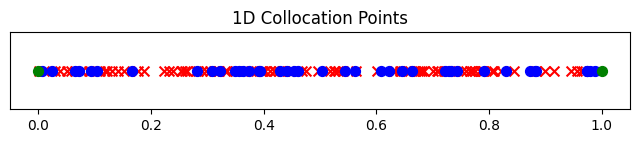

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 1))  # Width, Height
plt.scatter(train_collocation, np.zeros_like(train_collocation), color='red', s=50, marker='x')
plt.scatter(data_collocation, np.zeros_like(data_collocation), color='blue', s=50, marker='o')
plt.scatter(train_collocation_bcs, np.zeros_like(train_collocation_bcs), color='green', s=50)
plt.yticks([])  # Hide y-axis as it's irrelevant in 1D
plt.gca().axes.get_yaxis().set_visible(False)  # Another way to hide y-axis elements
plt.title('1D Collocation Points')

# **Step 5: Train the Neural Network**

Define a routine for train PINN for inverse problems.

Note that in the following training routine, we are also learning the values of parameter $\alpha$ in addition to the weights $\theta$ of the neural network.

In order to learn the values of $\alpha$ we can employ the Gradient Descent method:
$$
\alpha^{(k+1)} = \alpha^{(k)} - \gamma {\nabla \alpha^{(k)}},
$$
where $\beta$ is the learning rate.

In this case we have employed a momentum method $\mu_\alpha^{(0)}=0$ and momentum parameter $\beta_\mu \in (0.8,0.99)$:
$$
\mu_\alpha^{(k+1)} = \beta_\mu  \mu_\alpha^{(k)} + (1 - \beta_\mu) {\nabla \alpha^{(k)}},
$$
$$
\alpha^{(k+1)} = \alpha^{(k)} - \gamma \mu_\alpha^{(k+1)}.
$$


In [46]:
def train_model(model, optimizer, num_epochs, train_collocation, f_train, train_collocation_bc, g_bc, data_collocation, u_data, alpha, best_model_path):

    best_loss = float('inf')

    momentum_alpha = 0
    beta = 0.9  # Momentum hyperparameter, commonly set between 0.8 and 0.99
    lr_weights = 0.01

    # Dictionary to track losses
    loss_history = {'total': [], 'pde': [], 'bc': [], 'data': []}
    l2_history = {'train': []}
    alpha_history = {'alpha': []}

    # Define the weights for the loss terms and their optimizer
    w_data = torch.tensor(1.0, requires_grad=True)
    w_pde = torch.tensor(1.0, requires_grad=True)

    for epoch in range(num_epochs):
        train_collocation.requires_grad = True

        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            # Predict in the interior part and calculate the PDE loss
            u_pred_train = model(train_collocation)
            loss_pde = eval_loss_pde(u_pred_train, train_collocation, f_train, alpha)

            # Predict on the boundary and calculate the boundary loss
            u_nn_bc = model(train_collocation_bc)
            loss_bc = eval_loss_bc(u_nn_bc, g_bc)

            # Predict on the boundary and calculate the boundary loss
            u_nn_data = model(data_collocation)
            loss_data = eval_loss_data(u_nn_data,u_data)

            # Add all loss components
            w_pde = (loss_pde/loss_pde+loss_data).detach()
            w_data = (loss_data/loss_pde+loss_data).detach()
            w_pde.requires_grad = False
            w_data.requires_grad = False

            total_loss = loss_pde + loss_data

            # Log losses for analysis
            loss_history['pde'].append(loss_pde.item())
            loss_history['bc'].append(loss_bc.item())
            loss_history['data'].append(loss_data.item())
            loss_history['total'].append(total_loss.item())

            if total_loss.requires_grad:
                total_loss.backward()

            return total_loss

        # Update the weights using the optimizer
        optimizer.step(closure)

        # Access data without computing gradients
        with torch.no_grad():
            u_pred_train = model(train_collocation).squeeze()
            u_exact_train = analytical_u(train_collocation).squeeze()
            # Compute errors
            l2_train = compute_relative_l2_error(u_pred_train.detach(), u_exact_train)

            # Store error history
            l2_history['train'].append(l2_train.item())

            # Update alpha using gradient descent
            momentum_alpha = beta * momentum_alpha + (1 - beta) * alpha.grad

            # Update parameters
            alpha -= lr_weights * momentum_alpha

            # alpha -= alpha.grad * 0.01
            alpha_history['alpha'].append(alpha.item())
            alpha.grad.zero_()


        # Optional print statement every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1:4d}/{num_epochs:4d}], Total Loss: {loss_history["total"][-1]:.4e}, Data Loss: {loss_history["data"][-1]:.4e}, PDE Loss: {loss_history["pde"][-1]:.4e}, BC Loss: {loss_history["bc"][-1]:.4e}), alpha: {alpha_history["alpha"][-1]:.4e}')

        # Save the best model
        if loss_history["total"][-1] < best_loss:
            best_loss = loss_history["total"][-1]
            torch.save(model.state_dict(), best_model_path)

    return loss_history, l2_history, alpha_history

In [47]:
model = PDE_Net_adaptive(in_features=1, out_features=1, hidden_layers=2, hidden_features=50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
num_epochs = 5000
best_model_path = 'best_model_reg.pth'

# Define the weights for the loss terms and their optimizer
alpha = torch.tensor(1.0, requires_grad=True)
# alpha = torch.rand_like(train_collocation, requires_grad=True)
losses_history, l2_history, alpha_history = train_model(model, optimizer, num_epochs, train_collocation, f_train, train_collocation_bcs, g_bc, data_collocation, u_data, alpha, best_model_path)

Epoch [ 100/5000], Total Loss: 5.9904e-02, Data Loss: 5.5329e-02, PDE Loss: 4.5743e-03, BC Loss: 3.8214e-15), alpha: 1.5089e+00
Epoch [ 200/5000], Total Loss: 3.4704e-02, Data Loss: 3.2604e-02, PDE Loss: 2.0991e-03, BC Loss: 3.8214e-15), alpha: 1.6003e+00
Epoch [ 300/5000], Total Loss: 2.1780e-02, Data Loss: 1.9881e-02, PDE Loss: 1.8987e-03, BC Loss: 3.8214e-15), alpha: 1.6734e+00
Epoch [ 400/5000], Total Loss: 1.4160e-02, Data Loss: 1.2425e-02, PDE Loss: 1.7345e-03, BC Loss: 3.8214e-15), alpha: 1.7325e+00
Epoch [ 500/5000], Total Loss: 9.4491e-03, Data Loss: 7.8916e-03, PDE Loss: 1.5575e-03, BC Loss: 3.8214e-15), alpha: 1.7807e+00
Epoch [ 600/5000], Total Loss: 6.4603e-03, Data Loss: 5.0704e-03, PDE Loss: 1.3899e-03, BC Loss: 3.8214e-15), alpha: 1.8202e+00
Epoch [ 700/5000], Total Loss: 4.5202e-03, Data Loss: 3.2860e-03, PDE Loss: 1.2342e-03, BC Loss: 3.8214e-15), alpha: 1.8525e+00
Epoch [ 800/5000], Total Loss: 3.2315e-03, Data Loss: 2.1424e-03, PDE Loss: 1.0890e-03, BC Loss: 3.8214e

# **Step 6: Plotting the losses**

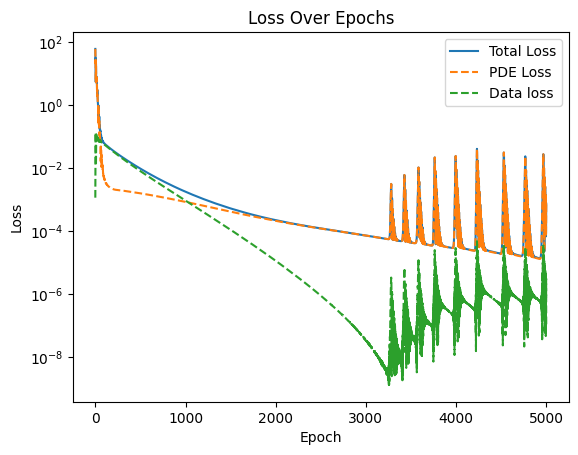

In [52]:
import matplotlib.pyplot as plt
plt.semilogy(losses_history['total'], label='Total Loss')
plt.semilogy(losses_history['pde'], label='PDE Loss', linestyle='--')
#plt.semilogy(losses_history['bc'], label='BC Loss', linestyle='--')
plt.semilogy(losses_history['data'], label='Data loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

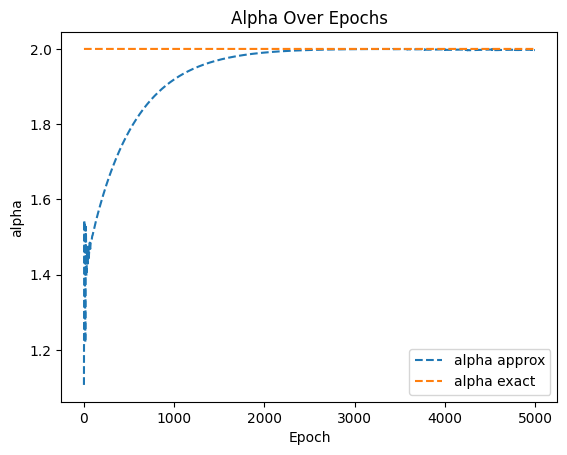

In [58]:
import matplotlib.pyplot as plt
plt.plot(alpha_history['alpha'], label='alpha approx', linestyle='--')
plt.plot(alpha_exact*np.ones(len(alpha_history['alpha'])), label='alpha exact', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('alpha')
plt.title('Alpha Over Epochs')
plt.legend()

# **Step 7a: Evaluate the Solution on testing data**

After training, you can evaluate the model by comparing its predictions with the exact solution.


In [54]:
x_test = torch.linspace(0, 1, 100).unsqueeze(1)  # Evaluate from 0 to 1
u_pred = model(x_test).detach().numpy()
u_exact = analytical_u(x_test).detach().numpy()


# **Step 7b: Visualization the solution**

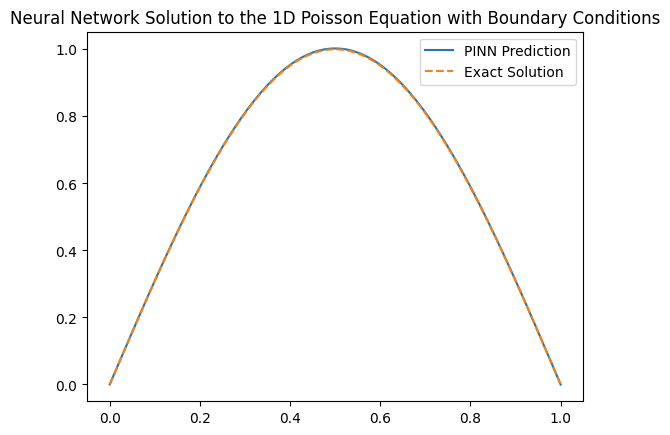

In [59]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_test.numpy(), u_pred, label='PINN Prediction')
plt.plot(x_test.numpy(), u_exact, label='Exact Solution', linestyle='--')
plt.legend()
plt.title('Neural Network Solution to the 1D Poisson Equation with Boundary Conditions')
plt.show()

# **Step 7c: Plot the error**

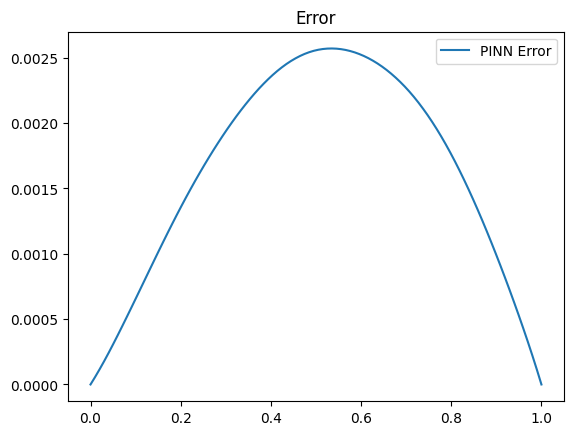

In [60]:
import numpy as np
error = (u_pred - u_exact)
plt.plot(x_test.numpy(), error, label='PINN Error')
plt.legend()
plt.title('Error')
plt.show()